## Training Process for Music Generation

Related blogposts:
For data preparation: https://medium.com/@cipher813/ai-jukebox-creating-music-with-neural-networks-1d9585c4d649
For model architecture: https://www.hackerearth.com/blog/machine-learning/jazz-music-using-deep-learning/

#### Importing dependecies

In [2]:
import sys
import glob
import pickle
import numpy as np
from keras import optimizers
from keras.models import Sequential, load_model
from keras.layers import Bidirectional, Dense, Dropout, LSTM, Activation
from keras.callbacks import ModelCheckpoint, TensorBoard, History, Callback
from keras.utils import np_utils
import re 
import pandas as pd
import music21
import IPython
from tqdm import tqdm
from playsound import playsound
from datetime import datetime
from music21 import converter, instrument, note, chord, stream

Using TensorFlow backend.


#### Getting the MIDI files for training & creating output notes file

In [8]:
#Get the midi files
midi_files = '/Users/anant.a.sharma/Desktop/Darya/AI-Jukebox/DATA/Ukrainian/*.midi'
timestamp = re.sub(r'[-: ]','',str(datetime.now()).split('.')[0])[:-2]
output_name = midi_files.split('/')[-2]
output_tag = '/Users/anant.a.sharma/Desktop/Darya/AI-Jukebox/DATA/output/{}-{}-'.format(timestamp, output_name)
songs = glob.glob(midi_files)

#Specify how many songs to take for training
songs = songs[:60]

In [9]:
songs

['/Users/anant.a.sharma/Desktop/Darya/AI-Jukebox/DATA/Ukrainian/oi_verbo__verbo.midi',
 '/Users/anant.a.sharma/Desktop/Darya/AI-Jukebox/DATA/Ukrainian/bila_mene_mati.midi',
 '/Users/anant.a.sharma/Desktop/Darya/AI-Jukebox/DATA/Ukrainian/dva_koloori.midi',
 '/Users/anant.a.sharma/Desktop/Darya/AI-Jukebox/DATA/Ukrainian/na_kalin__mene_mati_kolihala.midi',
 '/Users/anant.a.sharma/Desktop/Darya/AI-Jukebox/DATA/Ukrainian/ne_schebechi__soloveiku.midi',
 '/Users/anant.a.sharma/Desktop/Darya/AI-Jukebox/DATA/Ukrainian/kalina__chervona_kalina.midi',
 '/Users/anant.a.sharma/Desktop/Darya/AI-Jukebox/DATA/Ukrainian/ya___sara.midi',
 '/Users/anant.a.sharma/Desktop/Darya/AI-Jukebox/DATA/Ukrainian/ne_shumi_kalinonka.midi',
 '/Users/anant.a.sharma/Desktop/Darya/AI-Jukebox/DATA/Ukrainian/volinyanochka.midi',
 '/Users/anant.a.sharma/Desktop/Darya/AI-Jukebox/DATA/Ukrainian/dva_dubki.midi',
 '/Users/anant.a.sharma/Desktop/Darya/AI-Jukebox/DATA/Ukrainian/a_ya_chornyava.midi',
 '/Users/anant.a.sharma/Desktop

#### Convert MIDI file to list of notes and chords with music21 toolkit

In [10]:
# Create function get_notes() that will return a list of notes and chords present in the .mid file.

def get_notes():
        # convert midi file dataset to notes
    notes = [] # list of notes and chords
    note_count = 0
    print("\n**Loading Midi files**")
    for file in songs: # loading midi filepaths
        print(file)
        try:
            midi = converter.parse(file) # midi type music21.stream.Score
            parts = instrument.partitionByInstrument(midi)

            if parts:
                notes_to_parse = parts.parts[0].recurse()
            else:
                notes_to_parse = midi.flat.notes
            # notes_to_parse type music21.stream.iterator.RecursiveIterator
            for e in notes_to_parse:
                if isinstance(e, note.Note):
                    notes.append(str(e.pitch))
                elif isinstance(e, chord.Chord):
                    to_append = '.'.join(str(n) for n in e.normalOrder)
                    notes.append(to_append)
            note_count +=1
        except Exception as e:
            print(e)
            pass
    n_vocab = len(set(notes))
    print("Loaded {} midi files {} notes and {} unique notes".format(len(songs), len(notes), n_vocab))

    note_file = output_tag + 'input_notes'
    with open(note_file, 'wb') as f:
        pickle.dump(notes, f)
    print("Input notes/chords stored as {} then pickled at {}".format(type(notes), note_file))
    print("First 20 notes/chords: {}".format(notes[:20]))
    return notes

In [12]:
get_notes()


**Loading Midi files**
/Users/anant.a.sharma/Desktop/Darya/AI-Jukebox/DATA/Ukrainian/oi_verbo__verbo.midi
/Users/anant.a.sharma/Desktop/Darya/AI-Jukebox/DATA/Ukrainian/bila_mene_mati.midi
/Users/anant.a.sharma/Desktop/Darya/AI-Jukebox/DATA/Ukrainian/dva_koloori.midi
/Users/anant.a.sharma/Desktop/Darya/AI-Jukebox/DATA/Ukrainian/na_kalin__mene_mati_kolihala.midi
/Users/anant.a.sharma/Desktop/Darya/AI-Jukebox/DATA/Ukrainian/ne_schebechi__soloveiku.midi
/Users/anant.a.sharma/Desktop/Darya/AI-Jukebox/DATA/Ukrainian/kalina__chervona_kalina.midi
/Users/anant.a.sharma/Desktop/Darya/AI-Jukebox/DATA/Ukrainian/ya___sara.midi
File not found or no such format found for: /Users/anant.a.sharma/Desktop/Darya/AI-Jukebox/DATA/Ukrainian/ya___sara.midi
/Users/anant.a.sharma/Desktop/Darya/AI-Jukebox/DATA/Ukrainian/ne_shumi_kalinonka.midi
/Users/anant.a.sharma/Desktop/Darya/AI-Jukebox/DATA/Ukrainian/volinyanochka.midi
/Users/anant.a.sharma/Desktop/Darya/AI-Jukebox/DATA/Ukrainian/dva_dubki.midi
/Users/anant

['D4',
 'F#4',
 'A4',
 'D4',
 'F#4',
 'A4',
 'D4',
 'F#4',
 'A4',
 'A3',
 'C#4',
 'E4',
 'A3',
 'C#4',
 'E4',
 'A3',
 'C#4',
 'E4',
 'E4',
 'G#4',
 'B4',
 'E4',
 'G#4',
 'B4',
 'E4',
 'G#4',
 'B4',
 'A3',
 'C#4',
 'E4',
 'A3',
 'C#4',
 'E4',
 'A3',
 'C#4',
 'E4',
 'D4',
 'F#4',
 'A4',
 'D4',
 'F#4',
 'A4',
 'D4',
 'F#4',
 'A4',
 'A3',
 'C#4',
 'E4',
 'A3',
 'C#4',
 'E4',
 'A3',
 'C#4',
 'E4',
 'E4',
 'G#4',
 'B4',
 'E4',
 'G#4',
 'B4',
 'E4',
 'G#4',
 'B4',
 'E4',
 'G#4',
 'B4',
 'E4',
 'G#4',
 'B4',
 'A3',
 'C#4',
 'E4',
 'A4',
 'C#5',
 'E5',
 'A5',
 'D4',
 'F#4',
 'A4',
 'D4',
 'F#4',
 'A4',
 'D4',
 'F#4',
 'A4',
 'A3',
 'C#4',
 'E4',
 'A3',
 'C#4',
 'E4',
 'A3',
 'C#4',
 'E4',
 'E4',
 'G#4',
 'B4',
 'E4',
 'G#4',
 'B4',
 'E4',
 'G#4',
 'B4',
 'A3',
 'C#4',
 'E4',
 'A3',
 'C#4',
 'E4',
 'A3',
 'C#4',
 'E4',
 'D4',
 'F#4',
 'A4',
 'D4',
 'F#4',
 'A4',
 'D4',
 'F#4',
 'A4',
 'A3',
 'C#4',
 'E4',
 'A3',
 'C#4',
 'E4',
 'A3',
 'C#4',
 'E4',
 'E4',
 'G#4',
 'B4',
 'E4',
 'G#4',
 'B4',
 'E

### Generate Input and Output Sequences

A neural network accepts only real values as input and since the pitches in the notes list are in string format, we need to map each pitch in the notes list to an integer. 

Each input sequence will consist of 100 notes, while the output array stores the 101st note for the corresponding input sequence. So, the objective of the model will be to predict the 101st note of the input sequence of notes.

In [13]:
notes = get_notes()
sequence_length = 100
n_vocab = len(set(notes))

# Extract the unique pitches in the list of notes.
pitchnames = sorted(set(item for item in notes))

# Create a dictionary to map pitches to integers
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

network_input = []
network_output = []

# create input sequences and the corresponding outputs
for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i: i + sequence_length]
    sequence_out = notes[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])

n_patterns = len(network_input)

## Now, we reshape and normalize the input vector sequence before feeding it to the model. 
## Finally, we one-hot encode our output vector.

# reshape the input into a format comatible with LSTM layers 
network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))

# normalize input
network_input = network_input / float(n_vocab)

# one hot encode the output vectors
network_output = np_utils.to_categorical(network_output)



**Loading Midi files**
/Users/anant.a.sharma/Desktop/Darya/AI-Jukebox/DATA/Ukrainian/oi_verbo__verbo.midi
/Users/anant.a.sharma/Desktop/Darya/AI-Jukebox/DATA/Ukrainian/bila_mene_mati.midi
/Users/anant.a.sharma/Desktop/Darya/AI-Jukebox/DATA/Ukrainian/dva_koloori.midi
/Users/anant.a.sharma/Desktop/Darya/AI-Jukebox/DATA/Ukrainian/na_kalin__mene_mati_kolihala.midi
/Users/anant.a.sharma/Desktop/Darya/AI-Jukebox/DATA/Ukrainian/ne_schebechi__soloveiku.midi
/Users/anant.a.sharma/Desktop/Darya/AI-Jukebox/DATA/Ukrainian/kalina__chervona_kalina.midi
/Users/anant.a.sharma/Desktop/Darya/AI-Jukebox/DATA/Ukrainian/ya___sara.midi
File not found or no such format found for: /Users/anant.a.sharma/Desktop/Darya/AI-Jukebox/DATA/Ukrainian/ya___sara.midi
/Users/anant.a.sharma/Desktop/Darya/AI-Jukebox/DATA/Ukrainian/ne_shumi_kalinonka.midi
/Users/anant.a.sharma/Desktop/Darya/AI-Jukebox/DATA/Ukrainian/volinyanochka.midi
/Users/anant.a.sharma/Desktop/Darya/AI-Jukebox/DATA/Ukrainian/dva_dubki.midi
/Users/anant

In [14]:
print(network_input.shape)
print(network_output.shape)

(24424, 100, 1)
(24424, 350)


## Model Architecture

We will use keras to build our model architecture. We use a character level-based architecture to train the model. So each input note in the music file is used to predict the next note in the file, i.e., each LSTM cell takes the previous layer activation (a⟨t−1⟩) and the previous layers actual output (y⟨t−1⟩) as input at the current time step tt.

In [15]:
#Create LTSM neural network

from keras.models import Sequential
from keras.layers import Activation, Dense, LSTM, Dropout, Flatten

"""Create the model architecture"""
model = Sequential()
model.add(LSTM(128, input_shape=network_input.shape[1:], return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(Flatten())
model.add(Dense(256))
model.add(Dropout(0.3))
model.add(Dense(n_vocab))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

### Model Summary

Our music model consists of two LSTM layers with each layer consisting of 128 hidden layers. We use ‘categorical cross entropy‘ as the loss function and ‘adam‘ as the optimizer. Fig. below shows the model summary (after training).

In [16]:
#Training the model
from keras.callbacks import ModelCheckpoint, EarlyStopping
model_weights_directory = '/Users/anant.a.sharma/Desktop/Darya/AI-Jukebox/Weights/'
# # Create checkpoint to save the best model weights.
filepath = '/Users/anant.a.sharma/Desktop/Darya/AI-Jukebox/weights.hdf5'
es = EarlyStopping(monitor='loss', mode='auto', verbose=2, patience = 50, restore_best_weights=True)
epochs = 100
model.fit(network_input, network_output, epochs=epochs, batch_size=32, callbacks=[es], verbose = 2)
model.summary()
model.save_weights(os.path.join(model_weights_directory, "Weights_{}.h5".format(epoch+1)))
print('Saved Weights at epoch {} to file Weights1_{}.h5'.format(epoch+1, epoch+1))

Epoch 1/100
 - 193s - loss: 4.6349
Epoch 2/100
 - 189s - loss: 4.3753
Epoch 3/100
 - 194s - loss: 4.1358
Epoch 4/100
 - 187s - loss: 3.8684
Epoch 5/100
 - 186s - loss: 3.5744
Epoch 6/100
 - 185s - loss: 3.3209
Epoch 7/100
 - 184s - loss: 3.0631
Epoch 8/100
 - 181s - loss: 2.7836
Epoch 9/100
 - 184s - loss: 2.4802
Epoch 10/100
 - 181s - loss: 2.1581
Epoch 11/100
 - 182s - loss: 1.8435
Epoch 12/100
 - 183s - loss: 1.5307
Epoch 13/100
 - 183s - loss: 1.2414
Epoch 14/100
 - 186s - loss: 1.0053
Epoch 15/100
 - 182s - loss: 0.8082
Epoch 16/100
 - 183s - loss: 0.6673
Epoch 17/100
 - 187s - loss: 0.5672
Epoch 18/100
 - 181s - loss: 0.4977
Epoch 19/100
 - 181s - loss: 0.4457
Epoch 20/100
 - 187s - loss: 0.4157
Epoch 21/100
 - 181s - loss: 0.3770
Epoch 22/100
 - 181s - loss: 0.3486
Epoch 23/100
 - 180s - loss: 0.3255
Epoch 24/100
 - 180s - loss: 0.2981
Epoch 25/100
 - 186s - loss: 0.2885
Epoch 26/100
 - 181s - loss: 0.2856
Epoch 27/100
 - 181s - loss: 0.2645
Epoch 28/100
 - 185s - loss: 0.2608
E

NameError: name 'os' is not defined

In [19]:
import os

model.save_weights(os.path.join(model_weights_directory, "Weights_best.h5"))

## Music sample generation

Now that we have trained our model, we can use it to generate some new notes. To generate new notes, we need a starting note. So, we randomly pick an integer and pick a random sequence from the input sequence as a starting point.

In [27]:
# Generate a piano midi file """
#load the notes used to train the model
with open('/Users/anant.a.sharma/Desktop/Darya/AI-Jukebox/DATA/output/201901030032-Ukrainian-input_notes', 'rb') as filepath:
    notes = pickle.load(filepath)

# Get all pitch names
pitchnames = sorted(set(item for item in notes))
# Get all pitch names
n_vocab = len(set(notes))

print('Initiating music generation process.......')

note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

sequence_length = 100
network_input = []
for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])

print(network_input)

print('Loading Model weights.....')
model.load_weights('/Users/anant.a.sharma/Desktop/Darya/AI-Jukebox/Weights/Weights_best.h5')
print('Model Loaded')

#Generate notes from the neural network based on a sequence of notes 

# Pick a random integer
start = np.random.randint(0, len(network_input)-1)
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
    
# pick a random sequence from the input as a starting point for the prediction
pattern = network_input[start]
prediction_output = []
    
print('Generating notes........')

# generate 500 notes
for note_index in range(500):
    prediction_input = np.reshape(pattern, (1, len(pattern), 1))
    prediction_input = prediction_input / float(n_vocab)

    prediction = model.predict(prediction_input, verbose=0)

    # Predicted output is the argmax(P(h|D))
    index = np.argmax(prediction)
    # Mapping the predicted interger back to the corresponding note
    result = int_to_note[index]
    # Storing the predicted output
    prediction_output.append(result)

    pattern.append(index)
    # Next input to the model
    pattern = pattern[1:len(pattern)]

    print('Notes Generated...')

prediction_output




Initiating music generation process.......


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Genera

Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Generated...
Notes Genera

['A1',
 'F#2',
 '2.5',
 '1.2.4.6.9',
 'F#2',
 '1.4',
 '1.2.4.6.9',
 '9.2',
 '2.5',
 'F#2',
 '2',
 '0.6',
 'D2',
 'A4',
 'F4',
 'C3',
 'B2',
 '2.5.9',
 'B2',
 '7.9.1',
 'A1',
 '2.5.9',
 'G2',
 'C3',
 'D2',
 '9.2',
 'C3',
 'B2',
 '2.5.9',
 'B2',
 '7.9.1',
 'A1',
 '2.5.9',
 'G2',
 'F#2',
 'C2',
 'D2',
 '9.2',
 'F5',
 '2.5.6',
 '5.9',
 'F#2',
 '2.5.9',
 '0.6',
 'A1',
 '2.5.6',
 '2.5.9',
 '2.5.6',
 '9.2',
 '7.10.2',
 '0.6',
 'G1',
 '6.7.10',
 '7.10.2',
 '6.7.10.2',
 '9.2',
 'A5',
 'F5',
 'F#2',
 'C2',
 'D2',
 '2.5.6',
 '2.5.9',
 '2.5.6',
 '2.5.9',
 '9.0.2.5.6',
 'F4',
 'C3',
 'B2',
 '2.5.9',
 'B2',
 '7.9.1',
 'A1',
 '2.5.9',
 'G2',
 'C3',
 'D2',
 '9.2',
 'C3',
 'B2',
 '2.5.9',
 'B2',
 '7.9.1',
 'A1',
 '2.5.9',
 'G2',
 'F#2',
 'C2',
 'D2',
 '9.2',
 'F5',
 '2.5.6',
 '5.9',
 'F#2',
 '2.5.9',
 '0.6',
 'A1',
 '2.5.6',
 '2.5.9',
 '2.5.6',
 '9.2',
 '0.4.7',
 '0.6',
 'C2',
 '0.4.6',
 '0.2.4.7',
 '0.2.4.6.7',
 '5.9',
 'F#2',
 'C2',
 'F2',
 '5.6.9',
 '9.0.2.5',
 '5.6.9',
 '9.0.2.5',
 'C3',
 'F1',
 '5

Since the predicted output is an array of probabilities, we choose the output at the index with the maximum probability. Finally, we map this index to the actual note and add this to the list of predicted output. Since the predicted output is a list of strings of notes and chords, we cannot play it. Hence, we encode the predicted output into the MIDI format using the following method.

In [19]:
# create_midi(prediction_output):
#convert the output from the prediction to notes and create a midi file from the notes 
prediction_output = prediction_output
offset = 0
output_notes = []

# create note and chord objects based on the values generated by the model
for pattern in prediction_output:
    # pattern is a chord
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Accordion()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
    # pattern is a note
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Accordion()
        output_notes.append(new_note)

    # increase offset each iteration so that notes do not stack
    offset += 0.5

midi_stream = stream.Stream(output_notes)

print('Saving Output file as midi....')

midi_stream.write('midi', fp='/Users/anant.a.sharma/Desktop/Darya/AI-Jukebox/DATA/output/test_output2.mid')

Saving Output file as midi....


'/Users/anant.a.sharma/Desktop/Darya/AI-Jukebox/DATA/output/test_output2.mid'

### Playing the generated music

To play the generated MIDI in the Jupyter Notebook we use a function paly_music below.


In [29]:
import pygame

def play_music(music_file):
    """
    stream music with mixer.music module in blocking manner
    this will stream the sound from disk while playing
    """
    clock = pygame.time.Clock()
    try:
        pygame.mixer.music.load(music_file)
        print ("Music file %s loaded!" % music_file)
    except pygame.error:
        print ("File %s not found! (%s)" % (music_file, pygame.get_error()))
        return
    pygame.mixer.music.play()
    while pygame.mixer.music.get_busy():
        # check if playback has finished
        clock.tick(30)
# pick a midi music file you have ...
# (if not in working folder use full path)

def play_midi(midi_file):
    freq = 44100    # audio CD quality
    bitsize = -16   # unsigned 16 bit
    channels = 2    # 1 is mono, 2 is stereo
    buffer = 1024    # number of samples
    pygame.mixer.init(freq, bitsize, channels, buffer)

    # optional volume 0 to 1.0
    pygame.mixer.music.set_volume(0.8)
    try:
        play_music(midi_file)
    except KeyboardInterrupt:
        # if user hits Ctrl/C then exit
        # (works only in console mode)
        pygame.mixer.music.fadeout(1000)
        pygame.mixer.music.stop()
        raise SystemExit

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


## Let’s listen to our generated jazz piano music!

In [30]:
play_midi('/Users/anant.a.sharma/Desktop/Darya/AI-Jukebox/DATA/output/test_output2.mid')

Music file /Users/anant.a.sharma/Desktop/Darya/AI-Jukebox/DATA/output/test_output2.mid loaded!


SystemExit: 

/Users/anant.a.sharma/anaconda2/envs/PythonData/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Model Evaluation

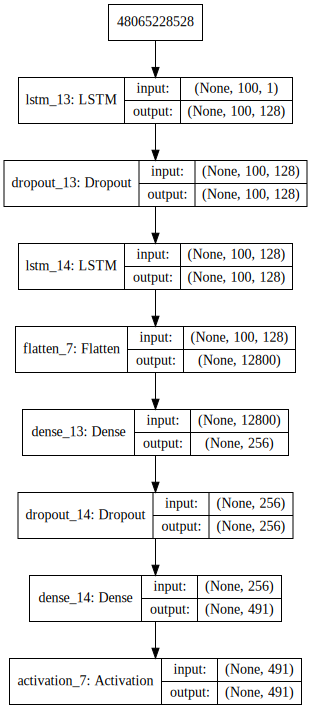

In [37]:
import os
import sys
import pydot
import graphviz
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

SVG(model_to_dot(saved_model, show_shapes=True).create(prog='dot', format='svg'))

NameError: name 'history' is not defined